In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from IPython.display import clear_output 
import threading
import imgaug.augmenters as iaa
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from random import sample, choice
from PIL import Image
import albumentations as albu

import time
import os
from tqdm.notebook import tqdm

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
#%matplotlib inline

In [3]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [4]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
x=splitfolders.ratio("../input/the-kvasir-dataset/kvasir-dataset-v2", output="spiltted",
    seed=0, ratio=(0.7,0.2,0.1)) # default values

# Split val/test with a fixed number of items, e.g. `(100, 100)`, for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
# Set 3 values, e.g. `(300, 100, 100)`, to limit the number of training values.
# splitfolders.fixed("../input/the-kvasir-dataset/kvasir-dataset-v2", output="split_data",
#    seed=1337, fixed=(700,200, 100), oversample=False, group_prefix=None, move=False) # default values

Copying files: 8000 files [00:53, 150.39 files/s]


In [5]:
data=ImageDataGenerator(rotation_range = 20, width_shift_range=0.05, shear_range=0.2,
                            zoom_range=0.2, fill_mode='nearest',
                            horizontal_flip=True, vertical_flip=True,
                            rescale=1/255)

  

train_dataset = data.flow_from_directory( directory='./spiltted/train',
                                        target_size=(224,224), batch_size=50, class_mode='categorical', 
                                        shuffle=True)

valid_dataset  =  data.flow_from_directory('./spiltted/val',
                        target_size=(224,224), batch_size=50, class_mode='categorical')
test_dataset = data.flow_from_directory('./spiltted/test',
                        target_size=(224,224),batch_size=10,class_mode='categorical',shuffle=False)

Found 5600 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [6]:
test_dataset.class_indices

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [ ]:
# def count(path):
#     x=[]
#     y=os.listdir(path)
#     for dirpath, dirnames, filenames in os.walk(path):
#         n=len(filenames)
#         x.append(n)
#     x=x[1:9]
#     new_dict = dict(zip(y, x))
#     return x,y,new_dict
#     def plot_count(x,y,new_dict):
#         plt.figure(figsize=(15, 6))
#         plt.bar(range(len(x)), list(new_dict.values()), align='center')
#         plt.xticks(range(len(x)), list(new_dict.keys()))
#         plt.title('Distribution of different classes in training datset')
#         plt.show()
    


In [ ]:
#     def plot_count(x,y,new_dict):
#         plt.figure(figsize=(15, 6))
#         plt.bar(range(len(x)), list(new_dict.values()), align='center')
#         plt.xticks(range(len(x)), list(new_dict.keys()))
#         plt.title('Distribution of different classes in training datset')
#         plt.show()

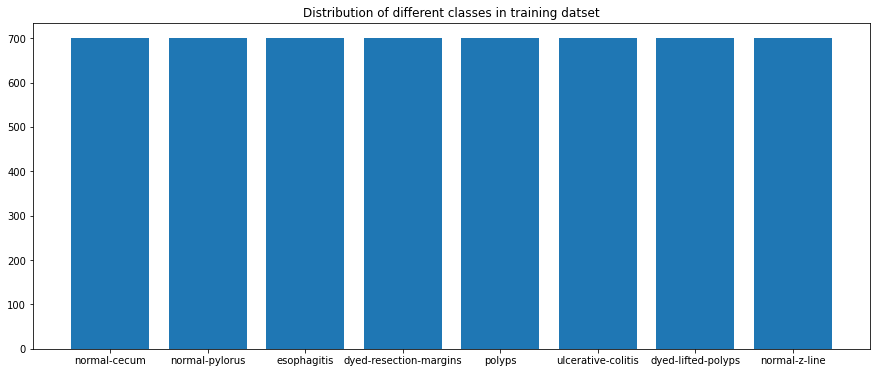

In [7]:
x=[]
path='./spiltted/train'
y=os.listdir(path)
for dirpath, dirnames, filenames in os.walk(path):
    n=len(filenames)
    x.append(n)
x=x[1:9]
new_dict = dict(zip(y, x))
plt.figure(figsize=(15, 6))
plt.bar(range(len(x)), list(new_dict.values()), align='center')
plt.xticks(range(len(x)), list(new_dict.keys()))
plt.title('Distribution of different classes in training datset')
plt.show()

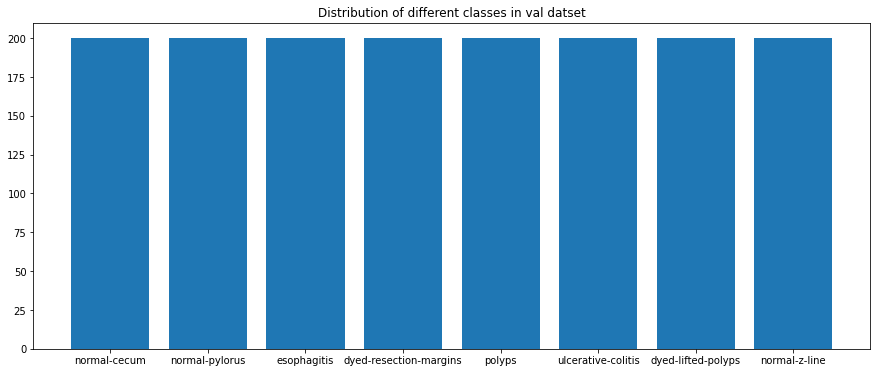

In [8]:
x=[]
path='./spiltted/val'
y=os.listdir(path)
for dirpath, dirnames, filenames in os.walk(path):
    n=len(filenames)
    x.append(n)
x=x[1:9]
new_dict = dict(zip(y, x))
plt.figure(figsize=(15, 6))
plt.bar(range(len(x)), list(new_dict.values()), align='center')
plt.xticks(range(len(x)), list(new_dict.keys()))
plt.title('Distribution of different classes in val datset')
plt.show()

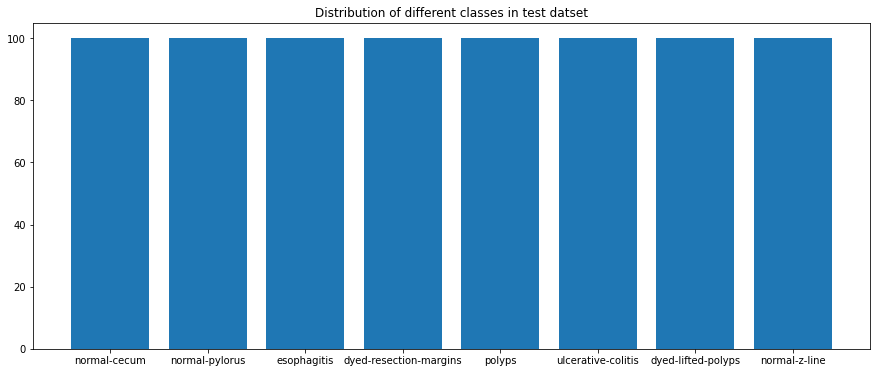

In [9]:
x=[]
path='./spiltted/test'
y=os.listdir(path)
for dirpath, dirnames, filenames in os.walk(path):
    n=len(filenames)
    x.append(n)
x=x[1:9]
new_dict = dict(zip(y, x))
plt.figure(figsize=(15, 6))
plt.bar(range(len(x)), list(new_dict.values()), align='center')
plt.xticks(range(len(x)), list(new_dict.keys()))
plt.title('Distribution of different classes in test datset')
plt.show()

In [10]:
# train_path='./spiltted/train'
# count(train_path)
# plot_count(x,y,new_dict)
# new_dict = dict(zip(y, x))
# plt.figure(figsize=(15, 6))
# plt.bar(range(len(x)), list(new_dict.values()), align='center')
# plt.xticks(range(len(x)), list(new_dict.keys()))
# plt.title('Distribution of different classes in training datset')
# plt.show()

In [11]:
# val_path='./spiltted/val'
# count(val_path)

# plt.figure(figsize=(15, 6))
# plt.bar(range(len(x)), list(new_dict.values()), align='center')
# plt.xticks(range(len(x)), list(new_dict.keys()))
# plt.title('Distribution of different classes in val datset')
# plt.show()

In [12]:
#@title Model_dict_initialization
import tensorflow_hub
#import tensorflow_addons as tfa
IMAGE_SHAPE = (224,224)


#url="https://tfhub.dev/google/imagenet/inception_v3/classification/5"
url="https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
#url="https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
#url="https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"
model = tf.keras.Sequential([
      tensorflow_hub.KerasLayer(url,trainable=False, input_shape=IMAGE_SHAPE+(3,)),
      tf.keras.layers.Dense(250, activation='relu'),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dense(8,activation='softmax')
      ])
#model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["categorical_accuracy", "Precision", "Recall"] )
#model.compile(loss=custom_binary_crossentropy_loss, optimizer='sgd', metrics=['accuracy'],run_eagerly=True )

#model_dict=dict(zip(classes,model_list))

2022-05-08 16:04:09.674662: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4226432   
_________________________________________________________________
dense (Dense)                (None, 250)               320250    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
Total params: 4,572,590
Trainable params: 346,158
Non-trainable params: 4,226,432
_________________________________________________________________


In [14]:
mc = ModelCheckpoint(mode='max', filepath='top-weights-na.h5', monitor='val_categorical_accuracy',save_best_only='True', verbose=1)
es = EarlyStopping(monitor='val_categorical_accuracy', patience=15, verbose=0)

In [15]:
history=model.fit(train_dataset,epochs=20, validation_data=valid_dataset, callbacks=[mc,es])

2022-05-08 16:13:09.964282: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
112/112 [==============================] - 274s 2s/step - loss: 0.5168 - categorical_accuracy: 0.7873 - precision: 0.8304 - recall: 0.7495 - val_loss: 0.4471 - val_categorical_accuracy: 0.8112 - val_precision: 0.8231 - val_recall: 0.7969

Epoch 00001: val_categorical_accuracy improved from -inf to 0.81125, saving model to top-weights-na.h5
Epoch 2/20
112/112 [==============================] - 265s 2s/step - loss: 0.3331 - categorical_accuracy: 0.8605 - precision: 0.8677 - recall: 0.8537 - val_loss: 0.3310 - val_categorical_accuracy: 0.8675 - val_precision: 0.8702 - val_recall: 0.8587

Epoch 00002: val_categorical_accuracy improved from 0.81125 to 0.86750, saving model to top-weights-na.h5
Epoch 3/20
112/112 [==============================] - 263s 2s/step - loss: 0.3029 - categorical_accuracy: 0.8788 - precision: 0.8859 - recall: 0.8718 - val_loss: 0.3704 - val_categorical_accuracy: 0.8456 - val_precision: 0.8461 - val_recall: 0.8381

Epoch 00003: val_categorical_accuracy did

In [16]:
test_dataset.class_indices

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

In [ ]:
labels=list(test_dataset.class_indices.keys())
labels.sort
labels

In [ ]:
lis1=list(test_dataset.classes)
lis2=list(y_pred)

In [ ]:
di=test_dataset.class_indices

In [ ]:
key= list(di.keys())
val=list(di.values())

In [ ]:
set(y_pred)

<AxesSubplot:>

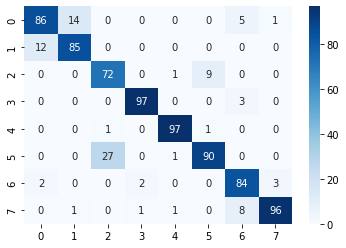

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import numpy as np
Y_pred = model.predict_generator(test_dataset)
y_pred = np.argmax(Y_pred, axis=1)

cm=confusion_matrix(y_pred, test_dataset.classes)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')

In [19]:
# test_dataset = data.flow_from_directory('./spiltted/test',
#                         target_size=(224,224),batch_size=1,class_mode='categorical',shuffle=False)
model.evaluate(test_dataset, verbose=1)

80/80 [==============================] - 30s 376ms/step - loss: 0.3342 - categorical_accuracy: 0.8813 - precision: 0.8857 - recall: 0.8813


[0.3341639041900635,
 0.8812500238418579,
 0.8856784105300903,
 0.8812500238418579]

In [25]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall'])

In [26]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss', marker='o')
    plt.plot( history.history['val_loss'], label='val_loss', marker='o')
    #plt.plot(history['train_loss_list'], label='train_loss', marker='o')
    plt.title('Loss'); plt.ylabel('Loss');
    plt.xlabel('Epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_accuracy(history):
    plt.plot(history.history['categorical_accuracy'], label='train_acc', marker='o')
    plt.plot( history.history['val_categorical_accuracy'], label='val_acc', marker='o')
    #plt.plot(history['train_loss_list'], label='train_loss', marker='o')
    plt.title('Accuracy'); plt.ylabel('Accuracy');
    plt.xlabel('Epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_precision(history):
    plt.plot(history.history['precision'], label='train_precision', marker='o')
    plt.plot( history.history['val_precision'], label='val_precision', marker='o')
    #plt.plot(history['train_loss_list'], label='train_loss', marker='o')
    plt.title('Precision'); plt.ylabel('Precision');
    plt.xlabel('Epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_recall(history):
    plt.plot(history.history['recall'], label='train_recall', marker='o')
    plt.plot( history.history['val_recall'], label='val_recall', marker='o')
    #plt.plot(history['train_loss_list'], label='train_loss', marker='o')
    plt.title('Recall'); plt.ylabel('Recall');
    plt.xlabel('Epoch')
    plt.legend(), plt.grid()
    plt.show()

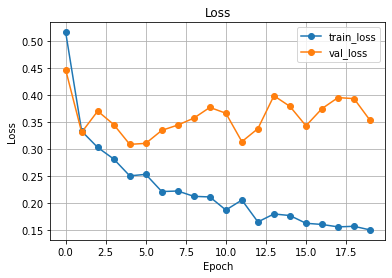

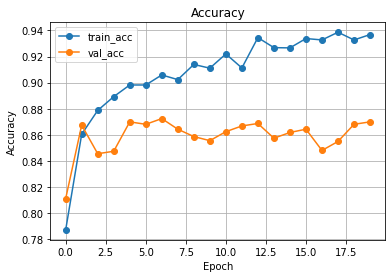

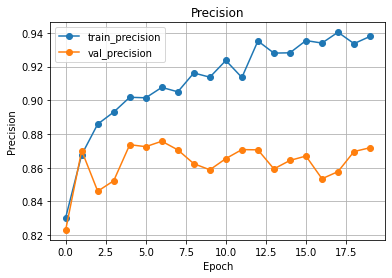

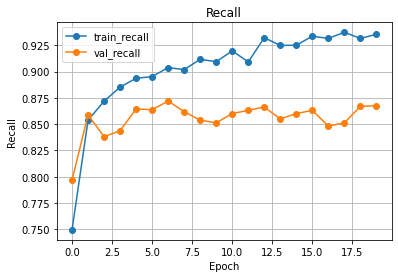

In [27]:
plot_loss(history)
plot_accuracy(history)
plot_precision(history)
plot_recall(history)

In [28]:
os.mkdir('/kaggle/working/mysaved_minor')

In [29]:
model.save('./mysaved_minor')

2022-05-08 18:00:00.503650: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [31]:
model = keras.models.load_model('/kaggle/working/mysaved_minor')

In [ ]:
model.predict()

In [40]:
import numpy as np
import cv2
# for dirpath, dirnames, filenames in os.walk('./spiltted/test'):
img=cv2.imread("./spiltted/val/normal-cecum/238e76e9-d1fc-4c83-8418-e9a268cb66e0.jpg")
res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
res = np.expand_dims(res, axis=0)
x=np.argmax(model.predict(res))
    
# model.predict(res)

In [41]:
x

4

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
import cv2
import numpy
import glob
for dirpath, dirnames, filenames in os.walk('./spiltted/test'):
#     folders = glob.glob(dirpath)

    imagenames_list = []
    for folder in dirpath:
        for f in glob.glob(dirpath+'/*.jpg'):
            imagenames_list.append(f)

    read_images = []        
    for image in imagenames_list:
        read_images.append(cv2.imread(image))

In [ ]:
len(read_images)

In [ ]:
os.mkdir('/kaggle/working/mysaved_minor')

In [ ]:
model.save('./mysaved_minor')


In [ ]:
# model = keras.models.load_model('./mysaved')

In [ ]:
x=[]
y=os.listdir(path)
for dirpath, dirnames, filenames in os.walk(path):
    n=len(filenames)
    x.append(n)
x=x[1:9]

In [ ]:
# a=os.listdir('./spiltted/test')
z=[]
for dirpath, dirnames, filenames in os.walk("./spiltted/test"):
#     print(dirpath)
#     print(dirnames)
#     print((filenames))
   
    if 'dyed-lifted-polyps' == dirpath:
        z.append(0*100)
#     filename_array=np.array(filenames)
#     print(filename_array.size )
        print(z)

In [ ]:
z

In [ ]:
z=[]
for i in range(8):
    z.append([i]*100)

In [ ]:
Y_test=z

In [ ]:
# y_pred=np.argmax(y_pred)
y_pred

In [ ]:
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# # Y_test=np.argmax(y_test, axis=1)
# y_pred=np.argmax(y_pred)
# cm=confusion_matrix(Y_test,y_pred)
# cm_plot=ConfusionMatrixDisplay(cm,display_labels=['0','1','2','3','4','5','6','7'])
# cm_plot.plot()
# plt.show()